# <a id='toc1_'></a>[Assignment 2](#toc0_)
### <a id='toc1_1_1_'></a>[Student ID: 460374219](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Assignment 2](#toc1_)    
    - [Student ID: 460374219](#toc1_1_1_)    
  - [Import Libraries](#toc1_2_)    
  - [Load Data](#toc1_3_)    
  - [Feature Selection](#toc1_4_)    
      - [Splitting the data](#toc1_4_1_1_)    
- [Model Selection](#toc2_)    
  - [Model Evaluation](#toc2_1_)    
  - [Optimisation](#toc2_2_)    
    - [Hyper-parameter tuning](#toc2_2_1_)    
      - [Normal Model](#toc2_2_1_1_)    
      - [Polynomial Model](#toc2_2_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Import Libraries](#toc0_)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## <a id='toc1_3_'></a>[Load Data](#toc0_)

In [30]:
def load_data():
    data = pd.read_csv('weatherAUS_clean.csv')
    return data

data = load_data()
data['Date'] = pd.to_datetime(data['Date'])

# drop NA
data = data.dropna()

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,14,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,15,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,16,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,5,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,14,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


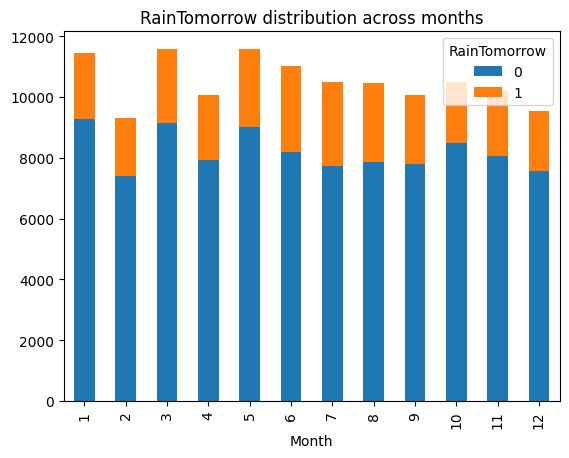

In [31]:
df = data.copy()

# Visualise the distribution of 1 and 0 in the RainTomorrow column across months
df["Month"] = data["Date"].dt.month

df.groupby(['Month', 'RainTomorrow']).size().unstack().plot(kind='bar', stacked=True)
plt.title('RainTomorrow distribution across months')
plt.show()

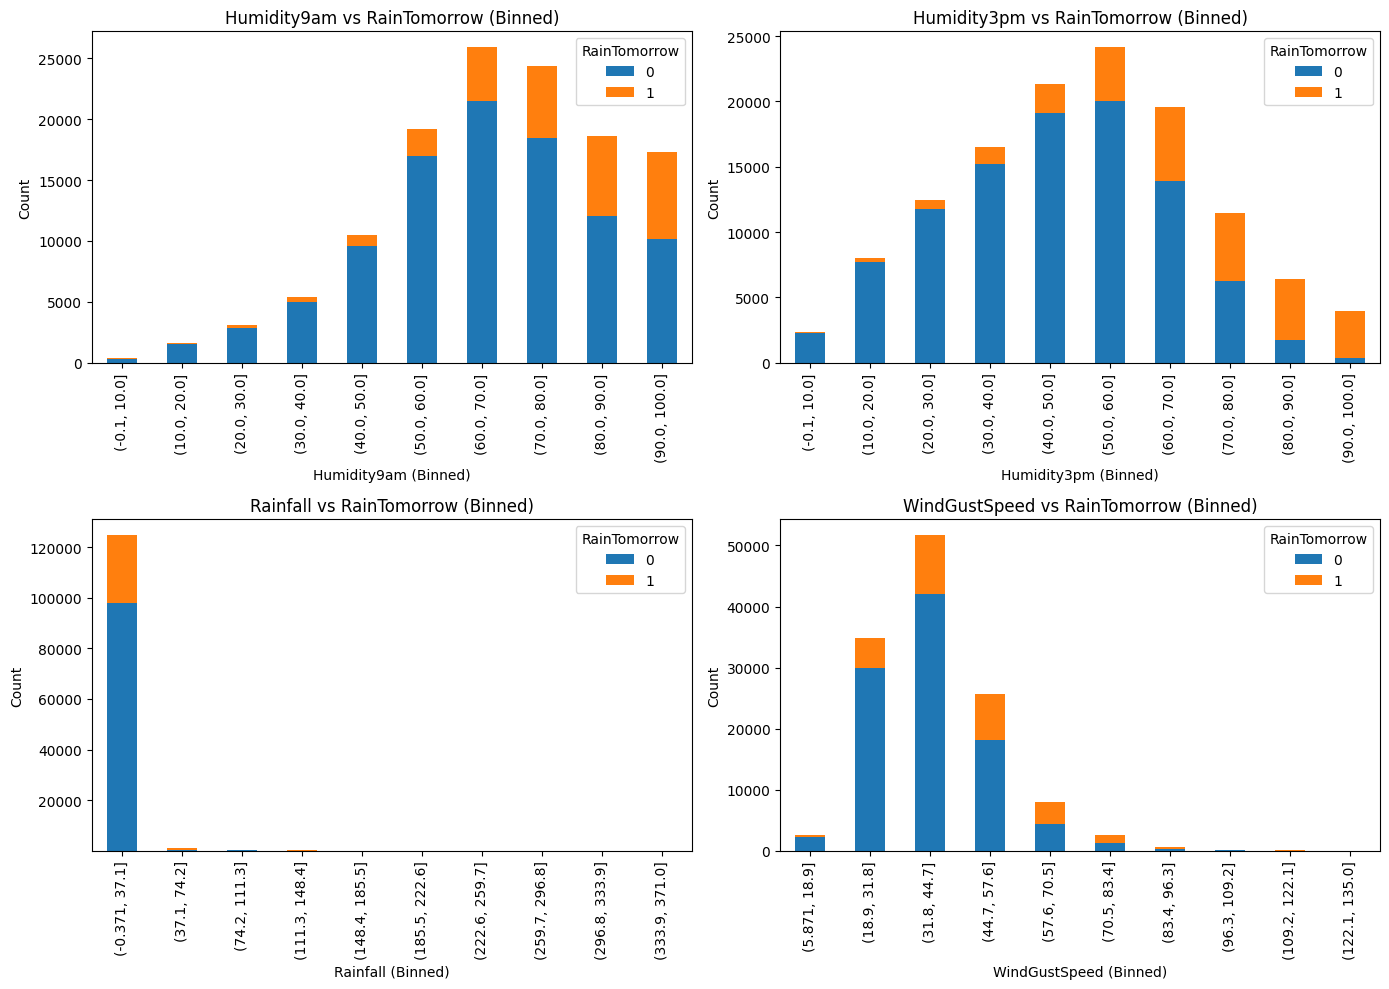

In [32]:
# Plot each feature against RainTomorrow
# group in bins
features = ["Humidity9am", "Humidity3pm", "Rainfall", "WindGustSpeed"]

df = data[features + ["RainTomorrow"]].copy()
# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

num_bins = 10

# Plot each feature
for i, feature in enumerate(features):
    df[f'{feature}_binned'] = pd.cut(df[feature], bins=num_bins)
    grouped = df.groupby([f'{feature}_binned', "RainTomorrow"], observed=False).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].set_title(f"{feature} vs RainTomorrow (Binned)")
    axs[i].set_ylabel("Count")
    axs[i].set_xlabel(f"{feature} (Binned)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Below we indentify the linearity of our data.

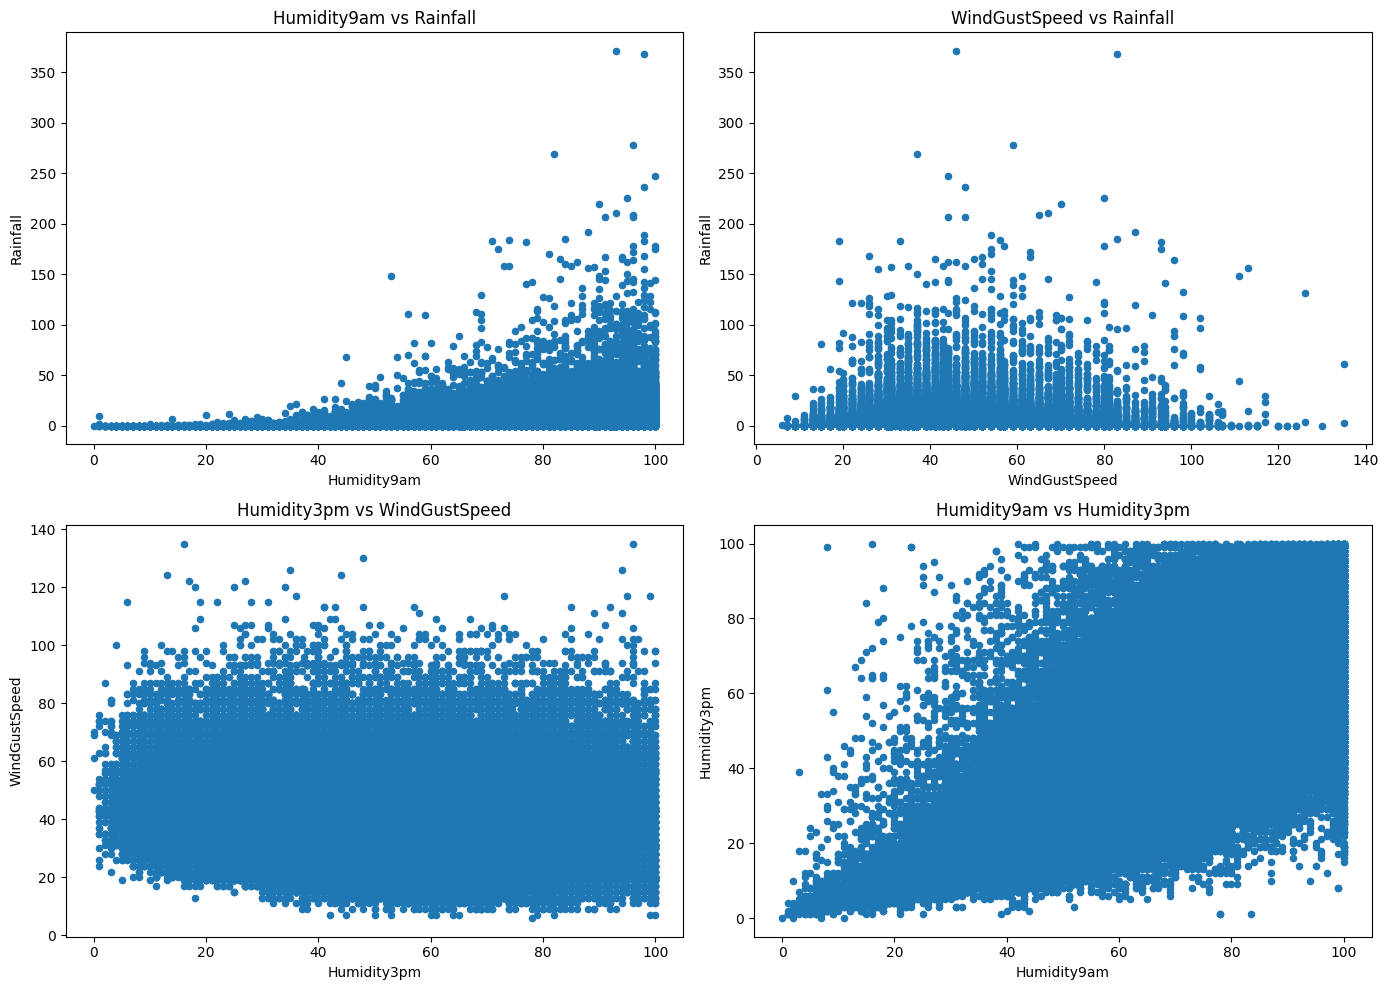

In [33]:
df = data.copy()

# Scatter plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Plot each feature
df.plot.scatter(x='Humidity9am', y='Rainfall', ax=axs[0])
axs[0].set_title(f"Humidity9am vs Rainfall")
axs[0].set_ylabel("Rainfall")
axs[0].set_xlabel(f"Humidity9am")

df.plot.scatter(x='WindGustSpeed', y='Rainfall', ax=axs[1])
axs[1].set_title(f"WindGustSpeed vs Rainfall")
axs[1].set_ylabel("Rainfall")
axs[1].set_xlabel(f"WindGustSpeed")

df.plot.scatter(x='Humidity3pm', y='WindGustSpeed', ax=axs[2])
axs[2].set_title(f"Humidity3pm vs WindGustSpeed")
axs[2].set_ylabel("WindGustSpeed")
axs[2].set_xlabel(f"Humidity3pm")

df.plot.scatter(x='Humidity9am', y='Humidity3pm', ax=axs[3])
axs[3].set_title(f"Humidity9am vs Humidity3pm")
axs[3].set_ylabel("Humidity3pm")
axs[3].set_xlabel(f"Humidity9am")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## <a id='toc1_4_'></a>[Feature Selection](#toc0_)

Below we use Chi-squared test to choose the best 4 features from the dataset.

In [34]:
# Feature selection using Chi-Squared test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Drop columns that are not needed
df = data.drop(columns=["Date", "Location"])

# Drop rows with missing values
df = df.dropna()

# Split the data into X and y
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# Fix negative values in X by raising them by the min negative value
X = X.abs()

# Apply SelectKBest class to extract top 4 best features
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X, y)

# Get the scores and feature names
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']

# Print the 4 best features
print(featureScores.nlargest(4, 'Score'))



          Feature          Score
2        Rainfall  225167.852361
10    Humidity3pm  214744.218113
9     Humidity9am   45800.847797
4   WindGustSpeed   30576.571794


In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          feature            VIF
0         MinTemp      42.164909
1         MaxTemp     526.572791
2        Rainfall       1.476117
3     WindGustDir       7.598634
4   WindGustSpeed      24.349046
5      WindDir9am       4.504827
6      WindDir3pm       6.257427
7    WindSpeed9am       6.808110
8    WindSpeed3pm      12.020586
9     Humidity9am      57.350225
10    Humidity3pm      43.234269
11    Pressure9am  426201.744749
12    Pressure3pm  425111.273861
13        Temp9am     168.163378
14        Temp3pm     573.181093
15      RainToday       2.092009


#### <a id='toc1_4_1_1_'></a>[Splitting the data](#toc0_)

In [36]:
from sklearn.model_selection import train_test_split

features = ["Humidity9am", "Humidity3pm", "Rainfall", "WindGustSpeed"]

# Numerical features with the most correlation with RainTomorrow
X = data[features]
y = data["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardise the data for logistic regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
print(X_train.shape)
print(X_test.shape)


(88335, 4)
(37859, 4)


(Optional) - Do polynomial feature selection

In [37]:
# Polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_poly.shape

(88335, 15)

# <a id='toc2_'></a>[Model Selection](#toc0_)

Normal Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

Polynomial Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
classifier_poly = LogisticRegression()
classifier_poly.fit(X_train_poly, y_train)

LogisticRegression()

## <a id='toc2_1_'></a>[Model Evaluation](#toc0_)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


def performance_overview(model, X_train, X_test, y_train, y_test):
    print(X_train.shape)
    print(X_test.shape)

    y_pred = model.predict(X_test)
    
    key='0=No Rain, 1=Rain'
    print('Classification report ({}):\n'.format(key))
    print(classification_report(y_test, y_pred))

    matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(matrix)
    print()

    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Without polynomial features

In [42]:
performance_overview(classifier, X_train, X_test, y_train, y_test)

(88335, 4)
(37859, 4)
Classification report (0=No Rain, 1=Rain):

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     29461
           1       0.73      0.46      0.56      8398

    accuracy                           0.84     37859
   macro avg       0.80      0.71      0.73     37859
weighted avg       0.83      0.84      0.83     37859

[[28075  1386]
 [ 4557  3841]]

Accuracy: 84.14 %
Standard Deviation: 0.19 %


With Polynomial Features

In [43]:
performance_overview(classifier_poly, X_train_poly, X_test_poly, y_train, y_test)

(88335, 15)
(37859, 15)
Classification report (0=No Rain, 1=Rain):

              precision    recall  f1-score   support

           0       0.86      0.95      0.91     29461
           1       0.74      0.46      0.57      8398

    accuracy                           0.85     37859
   macro avg       0.80      0.71      0.74     37859
weighted avg       0.84      0.85      0.83     37859

[[28101  1360]
 [ 4502  3896]]

Accuracy: 84.32 %
Standard Deviation: 0.21 %


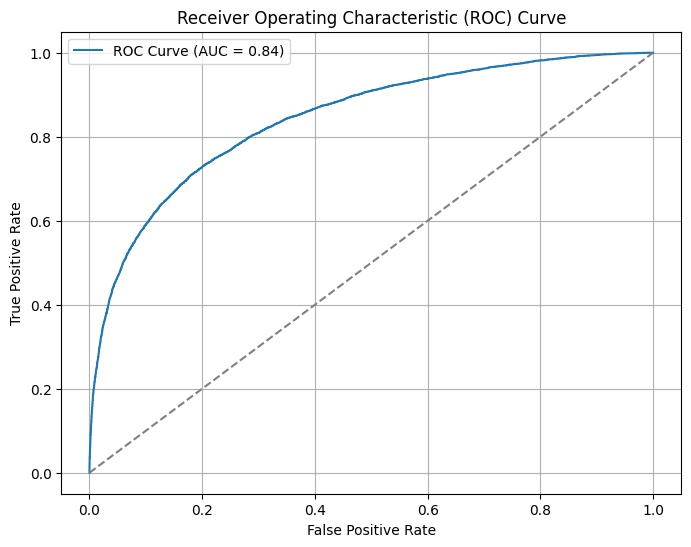

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()


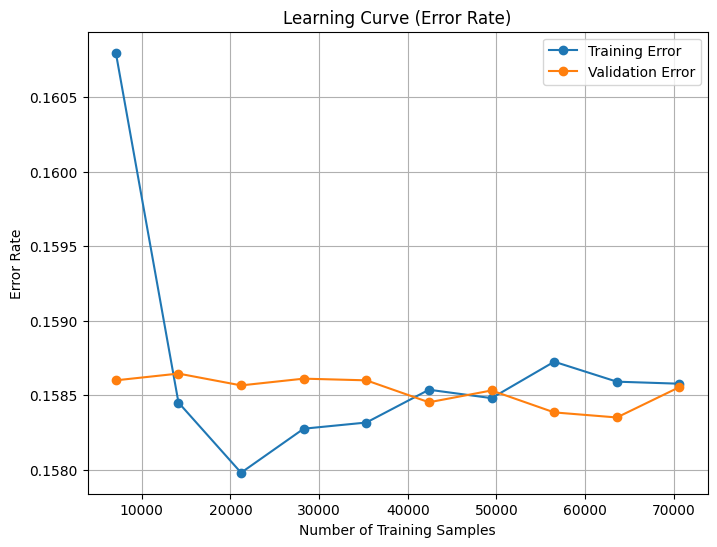

In [45]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define scoring metric ('accuracy' is common, but others like 'f1' or 'roc_auc' can be used)
scoring = 'accuracy'

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    classifier, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # From 10% to 100% of the data
)

# Calculate the mean and standard deviation of training and validation scores
train_errors = 1 - np.mean(train_scores, axis=1)
val_errors = 1 - np.mean(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes, val_errors, label='Validation Error', marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("Error Rate")
plt.title("Learning Curve (Error Rate)")
plt.legend()
plt.grid(True)
plt.show()


## <a id='toc2_2_'></a>[Optimisation](#toc0_)

Finding the best Threshold

In [46]:
# Source: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

from sklearn.metrics import accuracy_score

pred_proba_df = pd.DataFrame(classifier.predict_proba(X_test))
threshold_list = np.linspace(0.05, 1, 20)
accuracies = {}
for i in threshold_list:
    y_pred = pred_proba_df.map(lambda x: 1 if x > i else 0)
    test_accuracy = accuracy_score(
        y_test.values.reshape(y_test.values.size, 1),
        y_pred.iloc[:, 1].values.reshape(y_pred.iloc[:, 1].values.size, 1),
    )
    accuracies[i] = test_accuracy

best_threshold = max(accuracies, key=accuracies.get)
print(f"Best threshold: {best_threshold:.2f}, with accuracy: {accuracies[best_threshold]:.4f}")

Best threshold: 0.50, with accuracy: 0.8430


### <a id='toc2_2_1_'></a>[Hyper-parameter tuning](#toc0_)

Tuning the C and penalty hyperparameters of the logistic regression model using GridSearchCV.

#### <a id='toc2_2_1_1_'></a>[Normal Model](#toc0_)

In [137]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression()

# using pipeline to chain the steps together
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standard scalar
sc = StandardScaler()
pca = PCA()

# Create pipeline with standard scalar, principle component analysis, and our model
pipe = Pipeline(steps=[("sc", sc), ("pca", pca), ("logistic_Reg", log_reg)])

# Number of components to keep (this is just the number features we are using)
n_components = list(range(1, X.shape[1] + 1, 1))
print(n_components)

# Tuning the hyper-parameters
C = np.logspace(-4, 4, 50)
penalty = ["l1", "l2", "elasticnet", "none"]

parameters = dict(
    pca__n_components=n_components, logistic_Reg__C=C, logistic_Reg__penalty=penalty
)

# Grid search
clf = GridSearchCV(pipe, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

# Best hyper-parameters
print(f"Best Hyper-Parameters: {clf.best_params_}")
print(f"Best Score: {clf.best_score_:.2f}")


[1, 2, 3, 4]


/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/

Best Hyper-Parameters: {'logistic_Reg__C': 0.18420699693267145, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 4}
Best Score: 0.84


In [47]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=0.1842, penalty='l2')
classifier.fit(X_train, y_train)
performance_overview(classifier, X_train, X_test, y_train, y_test)

(88335, 4)
(37859, 4)
Classification report (0=No Rain, 1=Rain):

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     29461
           1       0.73      0.46      0.56      8398

    accuracy                           0.84     37859
   macro avg       0.80      0.71      0.73     37859
weighted avg       0.83      0.84      0.83     37859

[[28075  1386]
 [ 4558  3840]]

Accuracy: 84.14 %
Standard Deviation: 0.19 %


As you can see, 84% seems to be the upper limit of what this model can achieve and hyperparameter tuning does not seem to improve the model.

#### <a id='toc2_2_1_2_'></a>[Polynomial Model](#toc0_)

In [172]:
from sklearn.model_selection import GridSearchCV
log_reg_poly = LogisticRegression()

# using pipeline to chain the steps together
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standard scalar
sc = StandardScaler()
pca = PCA()

# Create pipeline with standard scalar, principle component analysis, and our model
pipe = Pipeline(steps=[("sc", sc), ("pca", pca), ("logistic_Reg", log_reg_poly)])

# Number of components to keep (this is just the number features we are using)
n_components = list(range(1, X.shape[1] + 1, 1))
print(n_components)

# Tuning the hyper-parameters
C = np.logspace(-4, 4, 50)
penalty = ["l1", "l2", "elasticnet", "none"]

parameters = dict(
    pca__n_components=n_components, logistic_Reg__C=C, logistic_Reg__penalty=penalty
)

# Grid search
clf = GridSearchCV(pipe, parameters, n_jobs=-1)
clf.fit(X_train_poly, y_train)

# Best hyper-parameters
print(f"Best Hyper-Parameters: {clf.best_params_}")
print(f"Best Score: {clf.best_score_:.2f}")


[1, 2, 3, 4]


/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/

Best Hyper-Parameters: {'logistic_Reg__C': 0.0029470517025518097, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 4}
Best Score: 0.83


In [48]:
from sklearn.linear_model import LogisticRegression
log_reg_poly = LogisticRegression(C=0.0029470, penalty='l2')
log_reg_poly.fit(X_train_poly, y_train)

performance_overview(log_reg_poly, X_train_poly, X_test_poly, y_train, y_test)

(88335, 15)
(37859, 15)
Classification report (0=No Rain, 1=Rain):

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     29461
           1       0.75      0.46      0.57      8398

    accuracy                           0.85     37859
   macro avg       0.80      0.71      0.74     37859
weighted avg       0.84      0.85      0.83     37859

[[28164  1297]
 [ 4566  3832]]

Accuracy: 84.32 %
Standard Deviation: 0.21 %
